
##### He Zhu     
#### Email: he.zhu@uconn.edu          

### 1. Machine Learning and Its Application in Stock Price Predicting

This part focuses on binary prediction of direction in asset price movement. To develop this topic, my report will includes 5 parts. 

1.1 The first part is to introduce the $basic$ $logic$ of this report 

1.2 The second part is about using $Logistic$ $Classifier$ to predict stock price direction.
    
    ****Our Logistic Regression Model is Penalised!!! The Detail of Penalisation will be attached at Appendix *****

    1.2.1 Introduction to Logistic Regression
    1.2.2 Logistic Regression on Simple Lagged Return Features
    1.2.3 Model Validation
        1.2.3.1 K-Fold Cross Valiation
        1.2.3.2 AUC Valiation
        1.2.3.3 Confusion Matrix
        1.2.3.4 Coefficient Analysis
    1.2.4 Extension I: Softmax Regression as Multinomial Logistic Regression
        1.2.4.1 Generalized Linear Model
            I.Bernoulli Distribution of Exponential Family Distribution
            II.Gaussian Distribution of Exponential Family Distribution
        1.2.5.1 General Approach to Construct GLM
            I.From GLM to OLS
            II.From GLM to Logistic Regression
    1.2.5 Extension II: Robust Model with Additional Features
        


1.3 The third part is using$Naive$ $Bayesian$ $Classifier$ to predict stock price direction.

    1.3.1 Introduction to Bayes Method
    1.3.2 
    1.3.3
    1.3.4
1.4 The fourth part is about using $Support$ $Vector$ $Machines$ to predict stock price direction.
    
    1.4.1 Feature Space and Kernal Method

1.5 The fifth part is about using $Decision\ Tree\ Classifier$ to make binary prediction, where Adaboost means will be used and the   algorithm visualisation will be provided.

1.6 The sixth part is about using $network/LTSM\ model$ to predict stock price direction. 


For better developing my report, all the parts will be equipped with necessary mathematical background.

For the development of my research report, I decided to choose three stocks in the same industry, they are VMW, MSFT and ORCL. They are all from Software-Infrastructure based on Yahoo Finance Stock Profile Data. Also, we have other data source, such as Morning Star, to determine their each industry.

#### 1.1 Introduction and Basic Logics
In this report, we will first design several features, or factors , such as Return Sign, OHLC, Momentum, Moving Average, Exponential MA.
Besides from those simple factors, I will develop some more complicated and advanced features and regimes under which our features may be stronger.At last, we will backtest our models one by one.

Now, let us start coding! We will first design some functions and import some Python modules we will use later.

##### Import Modules

In [535]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
from pylab import plt
plt.style.use('seaborn')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

##### We first Read data into Python Pandas Dataframe

In [536]:
VMW = pd.DataFrame(web.DataReader('VMW',data_source = 'yahoo'))
MSFT = pd.DataFrame(web.DataReader('MSFT',data_source ='yahoo'))
ORCL = pd.DataFrame(web.DataReader('ORCL',data_source = 'yahoo'))
VMW.head(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,43.799999,43.000000,43.150002,43.570000,1104400.0,36.194626
2010-01-05,45.500000,43.189999,43.720001,45.250000,2382600.0,37.590240
2010-01-06,46.459999,45.060001,45.330002,45.669998,2046800.0,37.939144



We will first focus on feature constructions
#### Feature 1 Lagged Returns
Here I provide a function to generate a dataframe with several days' lagged returns

In [537]:
def getLaggedReturns(df,lags = 5, window_length = 1):
    #df: pandas Dataframe type variable, and column 'Close' should be included
    #lags: how many lagged returns do you want
    #window_length: the window length we use to compute each return
    laggedReturns =pd.DataFrame(index = df.index)
    laggedReturns['Close'] = df['Close']
    laggedReturns['ret_0'] = np.log(laggedReturns['Close']/laggedReturns['Close'].shift(window_length))
    
        
    for lag in range( 1,lags + 1 ):
        col = 'ret_%d'%lag
        laggedReturns[col] = laggedReturns['ret_0'].shift(lag)
    laggedReturns.dropna(inplace = True)
    
    return laggedReturns

Sometimes the window-length of the return can also influence the model's robustness, for example, the weekly return maybe stronger when predicting mid-term price directions. But the point is that it is tough to determine what window-length to use. So this function adapt the parameter window_length to make our function more flexible.

Now let us turn to use this function to get lagged returns. Here we use window_length = 1 and lags = 5, which means that the return of stocks is computed in daily frequency and 6 lagged returns will be computed.(ret_0 means the most recent daily return)

In [538]:
VMW_laggedReturns = getLaggedReturns(VMW)
MSFT_laggedReturns = getLaggedReturns(MSFT)
ORCL_laggedReturns = getLaggedReturns(ORCL)
#Print one dataframe to make sure our data is correctly structured
VMW_laggedReturns.head(3)

,Close,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5
Date,,,,,,,
2010-01-12,44.630001,-0.004471,-0.009325,0.002434,-0.011673,0.009239,0.037834
2010-01-13,45.439999,0.017986,-0.004471,-0.009325,0.002434,-0.011673,0.009239
2010-01-14,47.450001,0.043284,0.017986,-0.004471,-0.009325,0.002434,-0.011673


Fully armed with these factors we can start our first model, the simple logistic model. More features will be created later but up to now I just stop here and I would like to turn to our first model.

#### 1.2 Logistic Regression

##### 1.2.1 Introduction to Binary Logistic Regression

Logistic is a $supervised$ $learning$ algorithm for $binary$ $classification$, where we usually make y can only be assigned with two values, 0 and 1. We can understand logistic regression in multiple aspects. 

For example you can understand logistic regression by regarding it as the $transformation$ from the OLS Linear Regression into $[0,1]$; 

More generally, you can understand it as a special form of the $posterior$ if some conditional distributional $P(x|y)$ is from $exponential$ $family$, where $x$ means input features, and $y$ is output, 0 or 1. For example, we can prove that one another classification method $Gaussian$ $Discriminative$ $Analysis$ can be converted into a logistic regression form mathematically. We can even prove that logistic regression can be constructed using $Generalized$ $Linear$ $Model$ where we usually assume the conditional distribution of output $y$ given x follows $Bernoulli$ $Distribution$, which is one of exponential family distribution.

All in all, we can derive and understand logistic in many ways, but the most important part we need to keep in mind that Logistic Regression Model is a robust model without strong distribution assumptions and a model from more generalized models.

Let us first have an easy impression on Logistic Regression Model's mathematical formula:

$$h_{\theta}(x) = g(\theta ^{T}x) = \frac{1}{1+e^{-\theta^{T}x}} \ \ \ \ \ \ \ \ (1)$$

As I mentioned before, logistic regression can be regarded as a transformation form of linear regression into value $[0,1]$, here as we can see, the value $-\theta^{T}x$ is actually a linear regression prediction. If $-\theta^{T}x$ is $0$, we can say that the predicted $-\theta^{T}x$ given a training set $x$ is on the decision boundary, and our $h_{\theta}(x) = g(\theta^{T}x)=0.5$, so we cannot determine which classification to put this sample. 

For the same reason we can conclude that 

as $-\theta^{T}x \to \infty$, our $h_{\theta}(x) \to 0$ and our predicted point will be deeper located in the class labeled with 0.

as $-\theta^{T}x \to -\infty$, our $h_{\theta}(x) \to 1$ and our predicted point will be deeper located in the class labeled with 1.


We can also regard $h_{\theta}(x)$ as a pseudo-distribution 

when $h_{\theta}(x) > 0.5$, we just say that the probability that the sample belongs to class 1 is larger, we simply put it into class 1, thus giving output $y=1$ 

when $h_{\theta}(x) < 0.5$, we just say that the probability that the sample belongs to class 1 is smaller, we simply put it into class 0, thus giving output $y=0$ 

So we can summarize that

$$
\begin{equation}
y = \begin{cases}
1, & \text{if } h_{\theta}(x) > 0.5;\\
0, & \text{if }h_{\theta}(x) < 0.5;
\end{cases}
\end{equation}
$$

The most usual way we use to fit parameters to a model is to use $Maximum$ $Likelihood$ $Estimation$. For estimation of parameters of logistic regression, we will use this method, too. But this time we will just stop by giving a Likelihood Function of Logistic Regression and the way by which we can approximate our parameters will only be mentioned but not developped. 

First, based on our discusson before, it is very natural to assume that

$$p(y=1| x;\theta) = h_{\theta}(x)$$

$$p(y = 0|x;\theta) = 1- h_{\theta}(x)$$

It will be a good habit to compact them together, then we get 

$$p(y|x;\theta) = (h_{\theta}(x))^{y}((1-h_{\theta}(x))^{1-y} \ \ \ \ \ \ \ (4)$$

Second, a very important assumption is needed. We assume that here are n training examples were independently generated. Only based on this strong assumption, we can product each sample's probability density function together to get our Maximum Likelihood Function. Now let us write it down:

$$L(\theta) = \prod^{n}_{i=1}p(y^{(i)}|x^{(i)};\theta)$$
$$=\prod^{n}_{i = 1}(h_{\theta}(x^{(i)}))^{y{(i)}}(1-h_{\theta}(x^{(i)}))^{1-y^{(i)}}$$

then we can easily get our log-likelihood function:

$$l(\theta) = logL(\theta)$$
$$ = \sum_{i=1}^{n}y^{(i)}logh(x^{(i)})+(1-y^{(i)})log(1-h(x^{(i)})) \ \ \ \ \ \ (5)$$

Now if we want to fit our $\theta$, we only need to $maximize$ $l(\theta)$. There are many methods can be used to maximize this function, such as Batch Gradient Descent Algorithm, Stochastic Gradient Descent Algorithm, Newton Methods and more. I will not discussed them here but will attach them in $Appendices$

##### 1.2.2 Logistic Model on Simple Lagged Return Features
We have previously created our first simple features Lagged Returns, now let use them as our first features to create our first classification model to predict stock price movement direction.

In [630]:
#import sklearn module for logistic regression
from sklearn import linear_model
#Create a list to store independent variables' keys
#Please remember that this list does not include 'ret_0' because our target is to predict 'ret_0' 
cols = ['ret_1', 'ret_2', 'ret_3', 'ret_4', 'ret_5']
#Here 'lbfgs' is a quasi-Newton method which we will not discuss more in this report
#LogisticRegression Type Object of Sklearn are created
lm_VMW = linear_model.LogisticRegression(C = 1e6,solver='lbfgs',multi_class='ovr',penalty='l2')
lm_MSFT = linear_model.LogisticRegression(C = 1e6,solver='lbfgs',multi_class='ovr',penalty='l2')
lm_ORCL = linear_model.LogisticRegression(C = 1e6,solver='lbfgs',multi_class='ovr',penalty='l2')

For $\text{Binary Logistic Classfication}$ Case, we need to notice that y can be only assigned with 1 or 0. So here we need to make the returns those larger than 0 to be 1 and less than or equal to 0 to be 0.

In [598]:
#So we first determine the direction of return for each ret_0
#Then we make those <0 to be = 0
VMW_laggedReturns['Sign']= np.sign(VMW_laggedReturns['ret_0'])
VMW_laggedReturns['Sign'][VMW_laggedReturns['Sign']<0] =0

MSFT_laggedReturns['Sign']= np.sign(MSFT_laggedReturns['ret_0'])
MSFT_laggedReturns['Sign'][MSFT_laggedReturns['Sign']<0] =0

ORCL_laggedReturns['Sign']= np.sign(ORCL_laggedReturns['ret_0'])
ORCL_laggedReturns['Sign'][ORCL_laggedReturns['Sign']<0] =0

In [599]:
###Fit our data using Lagged ret_1, ret_2, ret_3, ret_4, ret_5 with Output Sign +1 or -1
lm_VMW.fit(VMW_laggedReturns[cols],VMW_laggedReturns['Sign'])
lm_MSFT.fit(MSFT_laggedReturns[cols], MSFT_laggedReturns['Sign'])
lm_ORCL.fit(ORCL_laggedReturns[cols],ORCL_laggedReturns['Sign'])

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [600]:
###Now we using our model to do prediction
VMW_laggedReturns['Logit_Predict'] = lm_VMW.predict(VMW_laggedReturns[cols])
MSFT_laggedReturns['Logit_Predict'] = lm_MSFT.predict(MSFT_laggedReturns[cols])
ORCL_laggedReturns['Logit_Predict'] = lm_ORCL.predict(ORCL_laggedReturns[cols])
MSFT_laggedReturns.head(4)

,Close,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,Sign,Logit_Predict,Logit_Returns
Date,,,,,,,,,,
2010-01-12,30.070000,-0.006629,-0.012802,0.006873,-0.010454,-0.006156,0.000323,0.0,1.0,-0.006629
2010-01-13,30.350000,0.009269,-0.006629,-0.012802,0.006873,-0.010454,-0.006156,1.0,1.0,0.009269
2010-01-14,30.959999,0.019899,0.009269,-0.006629,-0.012802,0.006873,-0.010454,1.0,1.0,0.019899
2010-01-15,30.860001,-0.003235,0.019899,0.009269,-0.006629,-0.012802,0.006873,0.0,0.0,0.003235


Now as we can see the column 'Logit_Predict' will give us our prediction for future price movement. Here we still need a small modification on this column. I will set the 0's in this column back to be -1, then we can use this measure to better estimate future price movement  

In [601]:
VMW_laggedReturns['Logit_Predict'][VMW_laggedReturns['Logit_Predict']==0] = -1
MSFT_laggedReturns['Logit_Predict'][MSFT_laggedReturns['Logit_Predict']==0] = -1
ORCL_laggedReturns['Logit_Predict'][ORCL_laggedReturns['Logit_Predict']==0] = -1
MSFT_laggedReturns.head(4)

,Close,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,Sign,Logit_Predict,Logit_Returns
Date,,,,,,,,,,
2010-01-12,30.070000,-0.006629,-0.012802,0.006873,-0.010454,-0.006156,0.000323,0.0,1.0,-0.006629
2010-01-13,30.350000,0.009269,-0.006629,-0.012802,0.006873,-0.010454,-0.006156,1.0,1.0,0.009269
2010-01-14,30.959999,0.019899,0.009269,-0.006629,-0.012802,0.006873,-0.010454,1.0,1.0,0.019899
2010-01-15,30.860001,-0.003235,0.019899,0.009269,-0.006629,-0.012802,0.006873,0.0,-1.0,0.003235


Here we need a very strong assumption that once we get our predicted price movement direction, we assume that the next-day's return follows 

$$R_{t+1} = LogitPredic * R_{t}$$

which means if $LogitPredict = 1$ then the price movement direction will not change but if $LogitPredict = -1$, the price movement direction will change, and next day's return's absolute value keep same with the day before.

In [602]:
VMW_laggedReturns['Logit_Returns'] = VMW_laggedReturns['Logit_Predict'] * VMW_laggedReturns['ret_0']
MSFT_laggedReturns['Logit_Returns'] = MSFT_laggedReturns['Logit_Predict'] * MSFT_laggedReturns['ret_0']
ORCL_laggedReturns['Logit_Returns'] = ORCL_laggedReturns['Logit_Predict'] * ORCL_laggedReturns['ret_0']
VMW_laggedReturns.head(3)

,Close,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,Sign,Logit_Predict,Logit_Returns
Date,,,,,,,,,,
2010-01-12,44.630001,-0.004471,-0.009325,0.002434,-0.011673,0.009239,0.037834,0.0,1.0,-0.004471
2010-01-13,45.439999,0.017986,-0.004471,-0.009325,0.002434,-0.011673,0.009239,1.0,1.0,0.017986
2010-01-14,47.450001,0.043284,0.017986,-0.004471,-0.009325,0.002434,-0.011673,1.0,1.0,0.043284


Now we will use our predicted return to plot our Net Asset Value change!

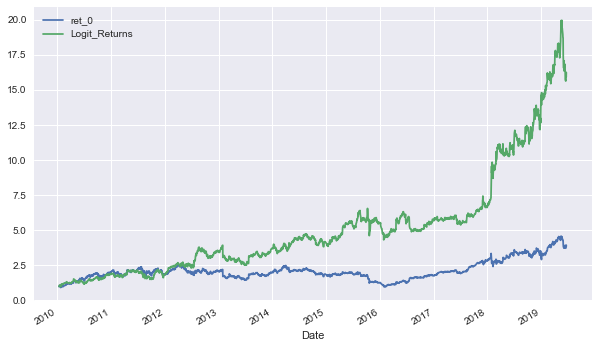

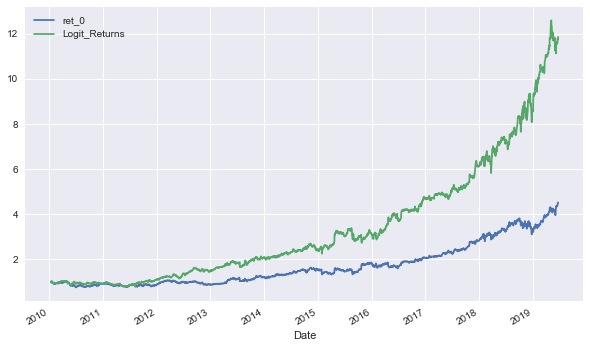

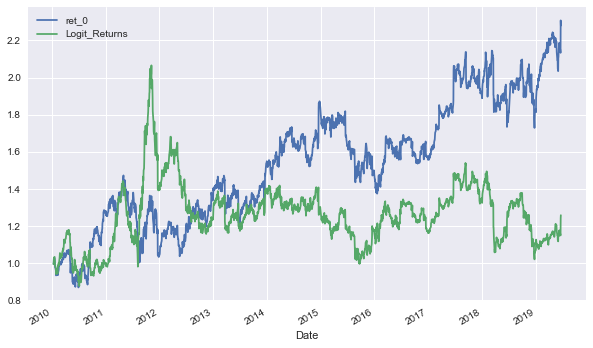

In [603]:
VMW_laggedReturns[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));
MSFT_laggedReturns[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));
ORCL_laggedReturns[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));

As we can see in these three figures, our estimation usually will overestimate stocks' future performance though the rough direction estimation is correct. We can say our model acctually predict the price movement direction.
#### No Training Set and Validation Set!!! 
But here exist a big danger in our model! We did not divide our dataset into $training$ $set$ and $validation$ $set$! Now I will divide our data set into two date set. We will use 70% of dataset as training set and 30% of dataset as validation set

In [604]:
#We need to note that all these 3 stocks have the same rows,or say that the same number of datasets 
num_training = int(0.7*VMW.shape[0])
train_VMW = VMW_laggedReturns.iloc[0:num_training,:]
train_MSFT = MSFT_laggedReturns.iloc[0:num_training,:]
train_ORCL = ORCL_laggedReturns.iloc[0:num_training,:]
test_VMW = VMW_laggedReturns.iloc[num_training:,:]
test_MSFT = MSFT_laggedReturns.iloc[num_training:,:]
test_ORCL = ORCL_laggedReturns.iloc[num_training:,:]

In [605]:
train_VMW.head(3)

,Close,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,Sign,Logit_Predict,Logit_Returns
Date,,,,,,,,,,
2010-01-12,44.630001,-0.004471,-0.009325,0.002434,-0.011673,0.009239,0.037834,0.0,1.0,-0.004471
2010-01-13,45.439999,0.017986,-0.004471,-0.009325,0.002434,-0.011673,0.009239,1.0,1.0,0.017986
2010-01-14,47.450001,0.043284,0.017986,-0.004471,-0.009325,0.002434,-0.011673,1.0,1.0,0.043284


In [606]:
###Fit our data agian
lm_VMW.fit(train_VMW[cols],train_VMW['Sign'])
lm_MSFT.fit(train_MSFT[cols],train_MSFT['Sign'])
lm_ORCL.fit(train_ORCL[cols],train_ORCL['Sign'])

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [607]:
#We predict our output Y
test_VMW['Logit_Predict'] = lm_VMW.predict(test_VMW[cols])
test_MSFT['Logit_Predict'] = lm_MSFT.predict(test_MSFT[cols])
test_ORCL['Logit_Predict'] = lm_ORCL.predict(test_ORCL[cols])

In [608]:
#As we did before, we need to set 'Logit_Predict' =0 to be -1
test_VMW['Logit_Predict'][test_VMW['Logit_Predict']==0] = -1
test_MSFT['Logit_Predict'][test_MSFT['Logit_Predict']==0] = -1
test_ORCL['Logit_Predict'][test_ORCL['Logit_Predict']==0] = -1

#Overwritting the previous data
test_VMW['Logit_Returns'] =test_VMW['ret_0']*test_VMW['Logit_Predict']
test_MSFT['Logit_Returns'] =test_MSFT['ret_0']*test_MSFT['Logit_Predict']
test_ORCL['Logit_Returns'] =test_ORCL['ret_0']*test_ORCL['Logit_Predict']
###Dont worry about warnings, it won't influence our analysis
test_VMW.head()

,Close,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,Sign,Logit_Predict,Logit_Returns
Date,,,,,,,,,,
2016-08-26,74.250000,-0.003764,-0.002145,0.001742,0.020049,0.003290,0.010905,0.0,-1.0,0.003764
2016-08-29,75.230003,0.013112,-0.003764,-0.002145,0.001742,0.020049,0.003290,1.0,1.0,0.013112
2016-08-30,74.220001,-0.013516,0.013112,-0.003764,-0.002145,0.001742,0.020049,0.0,-1.0,0.013516
2016-08-31,73.330002,-0.012064,-0.013516,0.013112,-0.003764,-0.002145,0.001742,0.0,1.0,-0.012064
2016-09-01,73.779999,0.006118,-0.012064,-0.013516,0.013112,-0.003764,-0.002145,1.0,1.0,0.006118


Now with seperate train set and validation set, we start to see the result of our model

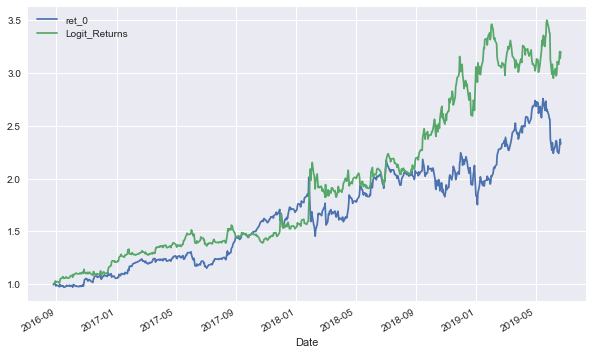

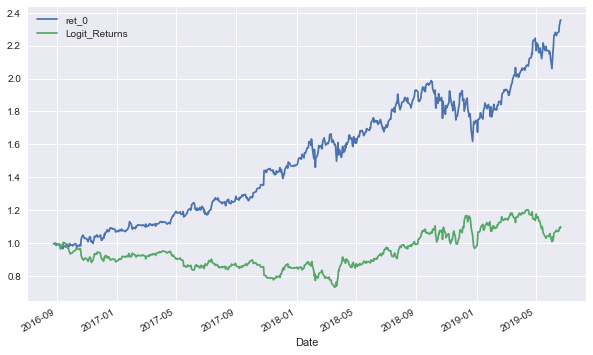

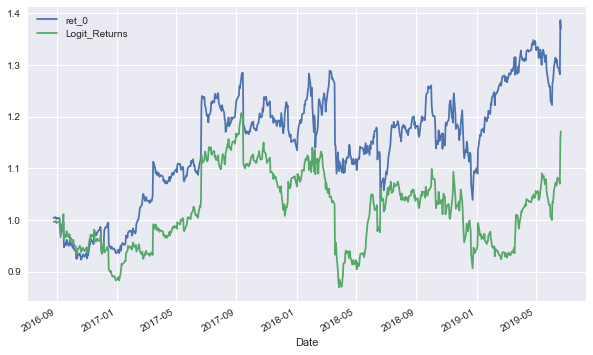

In [609]:
test_VMW[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));
test_MSFT[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));
test_ORCL[['ret_0', 'Logit_Returns']].cumsum().apply(np.exp).plot(figsize=(10, 6));

##### Transition Probability 
Though we have got our price prediction paths and it seems good, it can be better if we can get a transition probability of our model. Transition probability can help us discover the probability of a stock's price going up or down. It is simple to implement it using existing modules.

In [611]:
lm_VMW.predict_proba(train_VMW[cols])
lm_MSFT.predict_proba(train_MSFT[cols])
lm_ORCL.predict_proba(train_ORCL[cols])

array([[0.49086456, 0.50913544],
       [0.47039076, 0.52960924],
       [0.49082215, 0.50917785],
       ...,
       [0.48294801, 0.51705199],
       [0.49663609, 0.50336391],
       [0.46881519, 0.53118481]])

Here the left-most and the right-most value mean the probability output is -1 or 1. Most of transition probabilities are around 0.5, which are not very good results.

#### 1.2.3 Model Validation
Now with the seperation of training set and test set, our model still performs good in price movement direction prediction, but actually how good it is? Now I would like to introduce three mainly used model validation techniques to you. They are

(1) Cross-Validation, and in this report, K-Fold Cross validation will be developed

(2) AUC Validation, or Area under ROC curve validation.

(3) Confusion Matrix Validation, 

##### 1.2.3.1 K-Fold Cross Validation
Cross Validation is kind of out-of-sampling testing technique used to backtest how accurately our predictive model perform. Conventionally, our dataset is usually divided into two parts, training part and testing part, and cross validation is to test how good will our model perform in testing set with estimation from training set.

The basic steps of cross validation are

(1)First, we partite our data into complementary sets.Strictly speaking, there are no limit of set number, and we can partite our data set into thounsands part for backtesting if our dataset is large enough.

(2)Second, we choose one set as our training set to train our model

(3)Third, Test our model by running it on multiple different model

(4)Put our backtesting result together and average our backtesting result

There are many types of cross-validation techniques we usually use. Roughly we can seperate them into two types. 

The first type is Exhaustive Cross-Validation techniques, which try to train and test our model on all possible subsets. 

The second type is Non-Exhaustive Cross-Validation, which can be regarded as an approximation and simplicity of exhaustive validation, because we don't want to catch all possible validation possibilities. I won't talk more about details here. 

More information about cross-validation will be attached at appendices.


In this report, I will use a validation method called $k-fold$ $crossvalidation$ method. This method requires us to split our data set into K number of consecutive sections, and (k-1) subsets are used to train the model and the remained one is used to test our data. We will have k validation rounds and in each round, one subset plays the role of testing set and others plays the roles of training set. At last we can compute our Final Accuray by average our individual accuracy ratio  

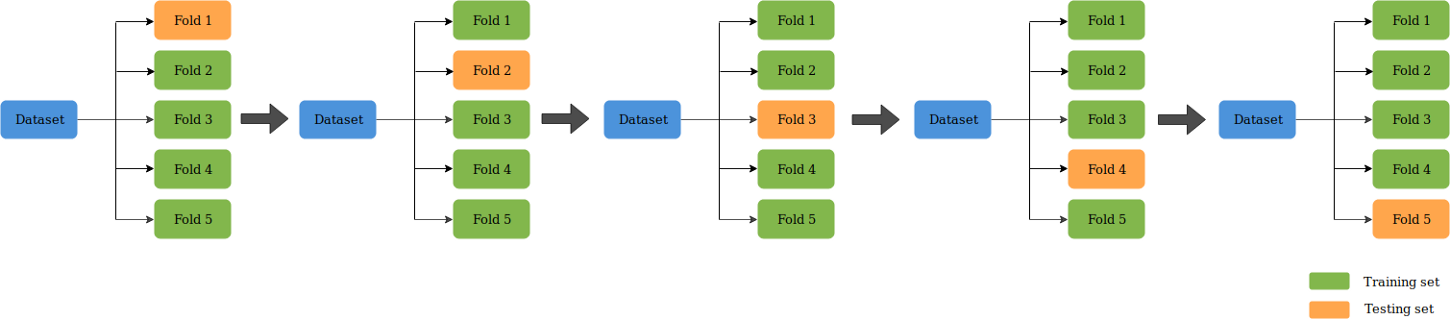


In [612]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#We first create a KFold object, and we define the number of sections to be 5
#Here shuffle= True means we will shuffle our data, or in other words, randomly sort it, before our split 
kfold = KFold(n_splits = 5,random_state=7,shuffle = True)
print(kfold)

KFold(n_splits=5, random_state=7, shuffle=True)


In [613]:
VMW_laggedReturns.iloc[:,2:7].head()

,ret_1,ret_2,ret_3,ret_4,ret_5
Date,,,,,
2010-01-12,-0.009325,0.002434,-0.011673,0.009239,0.037834
2010-01-13,-0.004471,-0.009325,0.002434,-0.011673,0.009239
2010-01-14,0.017986,-0.004471,-0.009325,0.002434,-0.011673
2010-01-15,0.043284,0.017986,-0.004471,-0.009325,0.002434
2010-01-19,-0.032776,0.043284,0.017986,-0.004471,-0.009325


In [631]:
###Now we get the number of splitting iterations in the cross-validator
kfold.get_n_splits(VMW_laggedReturns.iloc[:,2:7])

#We first cross-validate our VMW logit model
logit_VMW = linear_model.LogisticRegression(C=1e5,solver ='lbfgs',multi_class='auto',penalty='l2')
logit_VMW.fit(VMW_laggedReturns.iloc[:,2:7],np.sign(VMW_laggedReturns.iloc[:,1]))
crossval_VMW = cross_val_score(logit_VMW,VMW_laggedReturns.iloc[:,2:7],np.sign(VMW_laggedReturns.iloc[:,1]),cv=kfold,scoring = 'accuracy')
print("5-Fold Cross Validation Accuracy For VMW Logit Model: %.4f"%crossval_VMW.mean())

#We second cross-validate our MSFT logit model
logit_MSFT = linear_model.LogisticRegression(C=1e5,solver ='lbfgs',multi_class='auto',penalty='l2')
logit_MSFT.fit(MSFT_laggedReturns.iloc[:,2:7], np.sign(MSFT_laggedReturns.iloc[:,1]))
crossval_MSFT = cross_val_score(logit_MSFT,MSFT_laggedReturns.iloc[:,2:7],np.sign(MSFT_laggedReturns.iloc[:,1]),cv=kfold,scoring = 'accuracy')
print("5-Fold Cross Validation Accuracy For MSFT Logit Model: %.4f"%crossval_MSFT.mean())

#We second cross-validate our ORCL logit model
logit_ORCL = linear_model.LogisticRegression(C=1e5,solver ='lbfgs',multi_class='auto',penalty='l2')
logit_ORCL.fit(ORCL_laggedReturns.iloc[:,2:6], np.sign(ORCL_laggedReturns.iloc[:,1]))
crossval_ORCL = cross_val_score(logit_ORCL,ORCL_laggedReturns.iloc[:,2:7],np.sign(ORCL_laggedReturns.iloc[:,1]),cv=kfold,scoring = 'accuracy')
print("5-Fold Cross Validation Accuracy For MSFT Logit Model: %.4f"%crossval_ORCL.mean())

5-Fold Cross Validation Accuracy For VMW Logit Model: 0.5128
5-Fold Cross Validation Accuracy For MSFT Logit Model: 0.5192
5-Fold Cross Validation Accuracy For MSFT Logit Model: 0.5196


As we can see in result, our models are accurate enough, which means if we are interesting in doing intra-day trading, our algorithm can be very profitable. Now I will talk about one another validation techniques.

##### 1.2.3.2 AUC Validation

Let us first briefly have a basic concept of AUC validation. AUC is the abbreviation of Area under ROC curve, where ROC is the abbreviation of Receiver Operating Characteristic Curve.

ROC plots the relationship between True Positive Rate (TPR) and False Positive Rate(FPR), where

$$TPR = \frac{TP}{TP + FN}$$ 

$$FPR = \frac{FP}{FP + TN}$$
 
Here we meet many abbreviation which may confuse us much, so you can take a look at the figure below
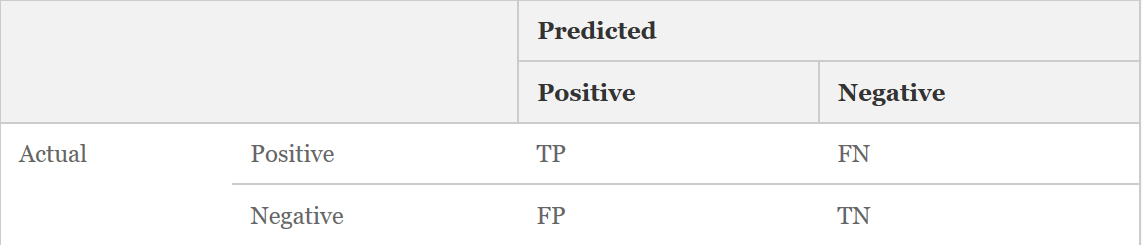

So in a binary classification problem, if the actual outcome should be positive and our predicted outcome is also positive, then we can say this predicted output is True Positive, then we can conclude that here $TF$ means the number of True Positive predicted output. Other three abbreviations also follow this rule.  


One of the best way to understand AUC is as the probability that the model ranks a random positive example more highly than a random negative example. For example, we have following figures, where examples are arranged from left to right in ascending order of logit regression predictions:
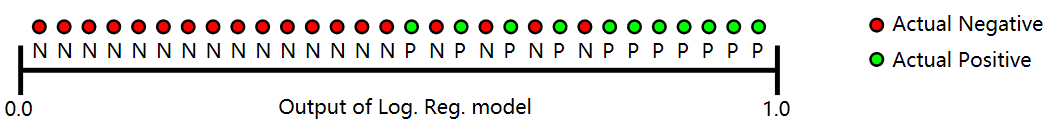

We can imagine that if a logit regression model rank samples in right order, the True Positive Rate will increase faster than False Positve Rate, thus the area under ROC curve is larger and grows faster to 1. You can understand it using very extreme circumstance where there are no false examples, which means that FN = 0 and FP = 0, than when FPR = 0 the TPR = 1, and then the ROC will be vertical to horizontal axis. Now let us start coding

$$\text{We first define the function for ROC plotting}$$

In [632]:
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import StratifiedKFold

#we first define a function to plot AUC
def plot_logit_ROC(default_ind,Y_test,X_test,logit,Y_response,X_features):
    #logit: We pass a defined LogisticRegression Object here
    #Y-Response: Y Population
    #X_Features: X Population
    #Y_test: testing set Y
    #X_test: testing set X
    
    # (1) Calculate AUC on testing set
    logit_roc_aucT = roc_auc_score(Y_test, logit.predict(X_test))
    # (2) calculate False Positive Rate and True Positive Rate on test set
    fprT,tprT,thresholdsT = roc_curve(Y_test,logit.predict_proba(X_test)[:,1],pos_label = default_ind)
    
    #(3)Calculate AUC on population testing set
    logit_roc_aucP = roc_auc_score(Y_response,logit.predict(X_features))
    #(4)calculate False Positive Rate and True Positive Rate on Population
    fprP,tprP,threasholdsP = roc_curve(Y_response,logit.predict_proba(X_features)[:,1],pos_label=default_ind)
    
    fig,ax = plt.subplots(figsize=(10,8))
    
    #Plot diagnoal line
    ax.plot([0,1],[0,1],'r--',label = "Random Classifier")
    
    #Plot ROC for predictions on testing set
    ax.plot(fprT,tprT,label = 'Train/Test Regression (area = %0.2f)'%logit_roc_aucT)
    
    #Plot ROC curve for the prediction on full set
    ax.plot(fprP,tprP,label = 'Population Regression (area = %0.2f)'%logit_roc_aucP)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()
    
    return ax

##### VMW ROC & AUC

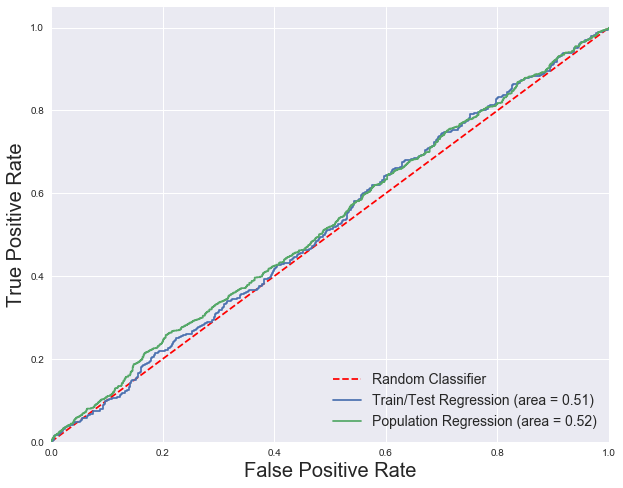

In [633]:
#plot_logit_ROC(default_ind,Y_test,X_test,logit,Y_response,X_features)
X_Train_VMW, X_Test_VMW, Y_Train_VMW, Y_Test_VMW = model_selection.train_test_split(VMW_laggedReturns.iloc[:,2:7],
                                                                                    VMW_laggedReturns['Sign'] ,
                                                                                    test_size=0.6, shuffle=True)
logit_VMW = linear_model.LogisticRegression(C = 1e15,solver ='lbfgs')
logit_VMW.fit(X_Train_VMW,Y_Train_VMW)
plot_logit_ROC(1,Y_Test_VMW,X_Test_VMW,logit_VMW,VMW_laggedReturns['Sign'],VMW_laggedReturns.iloc[:,2:7])

###Here we plot the ROC and Calculate the AUC of VMW Logit Regression Model

##### MSFT AUC & ROC

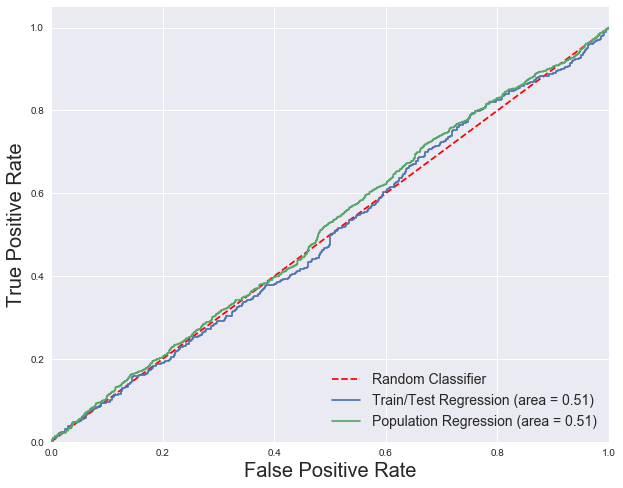

In [634]:
X_Train_MSFT, X_Test_MSFT, Y_Train_MSFT, Y_Test_MSFT = model_selection.train_test_split(MSFT_laggedReturns.iloc[:,2:7],
                                                                                    MSFT_laggedReturns['Sign'],
                                                                                    test_size=0.6, shuffle=True)
logit_MSFT= linear_model.LogisticRegression(C = 1e15,solver ='lbfgs')
logit_MSFT.fit(X_Train_MSFT,Y_Train_MSFT)
plot_logit_ROC(1,Y_Test_MSFT,X_Test_MSFT,logit_MSFT,MSFT_laggedReturns['Sign'],MSFT_laggedReturns.iloc[:,2:7])

###Here we plot the ROC and Calculate the AUC of MSFT Logit Regression Model

##### ORCL AUC&ROC

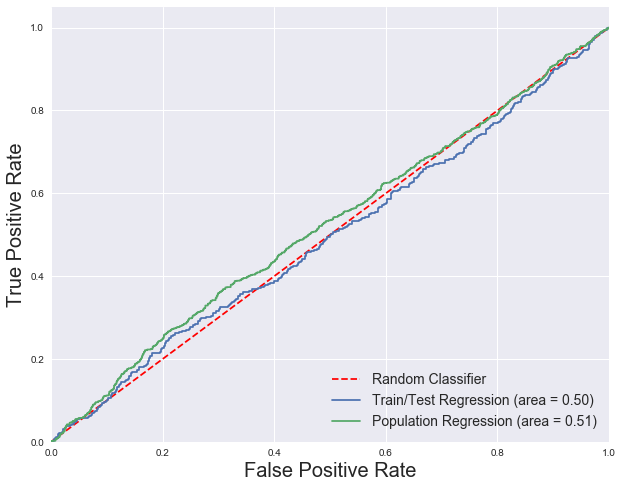

In [635]:
X_Train_ORCL, X_Test_ORCL, Y_Train_ORCL, Y_Test_ORCL = model_selection.train_test_split(ORCL_laggedReturns.iloc[:,2:7],
                                                                                    ORCL_laggedReturns['Sign'],
                                                                                    test_size=0.6, shuffle=True)
logit_ORCL = linear_model.LogisticRegression(C = 1e15,solver ='lbfgs')
logit_ORCL.fit(X_Train_ORCL,Y_Train_ORCL)
plot_logit_ROC(1,Y_Test_ORCL,X_Test_ORCL,logit_ORCL,ORCL_laggedReturns['Sign'],ORCL_laggedReturns.iloc[:,2:7])
###Here we plot the ROC and Calculate the AUC of ORCL Logit Regression Model

So based on our analysis before, we can say that these 3 models are not significantly valid(above 45' line).So we cannot easily belive that this model can help us earn more in stock market

##### 1.2.3.3 Confusion Matrix Validation

Confusion Matrix is one another frequently used validation technique to evaluate classification model's accuracy. Different from AUC validation which focuses more on True Positive Rate and False Positive Rate, confusion matrix focuses more on True Positive Number and True Negative Number.

Let us code it for clear

In [636]:
#First import module we will use for confusion matrix analysis
from sklearn.metrics import confusion_matrix

#Compute Confusion Matrix for VMW Logit Regression Model
Y_VMW_pred = logit_VMW.predict(X_Test_VMW)
confusion_matrix_VMW = confusion_matrix(Y_Test_VMW,Y_VMW_pred)
#Compute Confusion Matrix for MSFT Logit Regression Model
Y_MSFT_pred = logit_MSFT.predict(X_Test_MSFT)
confusion_matrix_MSFT = confusion_matrix(Y_Test_MSFT,Y_MSFT_pred)
#Compute Confusion Matrix for ORCL Logit Regression Model
Y_ORCL_pred = logit_ORCL.predict(X_Test_ORCL)
confusion_matrix_ORCL = confusion_matrix(Y_Test_ORCL,Y_ORCL_pred)

In [637]:
print("VMW Confusion Matrix")
print(confusion_matrix_VMW)
print("MSFT Confusion Matrix")
print(confusion_matrix_MSFT) 
print("ORCL Confusion Matrix")
print(confusion_matrix_ORCL)

VMW Confusion Matrix
[[303 356]
 [333 435]]
MSFT Confusion Matrix
[[135 570]
 [121 601]]
ORCL Confusion Matrix
[[227 455]
 [255 490]]


Now with these confusion matrix, we can better understand what actually goes on. In each matrix, here are four elements. 

Take VMW confusion matrix as an example, 
1. the upper-left element is the number of True Positive Samples, which is 191, and the right-upper element is the number of False Negative Samples, which is 490. So, the actual postive sample number should be 191 + 490 = 781, and our model catch 191/781 actual positive sample correctly, it is not very ideal.  


2. the lower-left element is the number of False Positive Samples, which is 204, and the right-lower element is the number of True Negative Samples, which is 514. So, the actual negative sample number should be 204 + 542 = 756, and our model catch 204/752 actual positive sample correctly, it is not an  ideal result.

3. Totally, we can find our model tends to regard more samples to be negative, and this phenomenon is absoulutely not occassional, because from all the three confusion matrix, the right side numbers are always higher than those in the left.

#### 1.2.3.4 Coefficient Analysis
The final analysis we will do one logistic regression model is a simple coefficient analysis. We have done model fitting before, so we can easily do some coefficient analysis in several short codes 

In [638]:
print('Coefficient for Logit Regression on VMW : ')
print(logit_VMW.coef_.ravel())
print('Coefficient for Logit Regression on MSFT : ')
print(logit_MSFT.coef_.ravel())
print('Coefficient for Logit Regression on ORCL : ')
print(logit_ORCL.coef_.ravel())

Coefficient for Logit Regression on VMW : 
[-4.34395922  1.47993664 -3.65385306  0.15376693 -5.46774802]
Coefficient for Logit Regression on MSFT : 
[-2.48387062 -1.4369694  -8.15110649 -3.3179879  -4.63849458]
Coefficient for Logit Regression on ORCL : 
[-6.59664381 -5.06298189 -6.89056351  4.76572666  0.0648829 ]


According to some simple observations, we can conclude that there are no consistent relationship between future price movement with lagged returns among these three stocks.

All in All, based on all the validation and analysis we did before, our models do not perform strong. But it does not mean that classifcation algorithm will always fail in this kind of case. Actually, some models, for example $\text{Multinomial Logistic Model}$, a generalized model of our classical $\text{Binary Logistic Model}$ will perform very strong. I will talk about it in the extension part.

#### 1.2.4 Extension I: Softmax Regression as Multinomial Logistic Regression

Based on our model used before, our model does not perform very strong, but it doest not mean that our model will perform worse in all classfication models. Actually, here exist some more generative form of Logistic Regression Model can make our prediction more accurate.
We call it $\text{Softmax Regression}$，or we can call it $\text{Multinomial Logistic Regression}$.

For better developing Multinomial Logistic Regression, we need first explore one another term called $\text{Generalized Linear Model}$

##### 1.2.4.1 Generalized Linear Model

We know $\text{Ordinary Linear Regression}$, under which we assume $y|x;\theta \sim N(\mu,\sigma^2)$, We also know our classical $\text{Logistic Regression}$, under which we assume $y|x; \theta \sim Bernoulli(\phi)$. Sometimes we may regard them as two different modeling techniques, one for regression and another one for classification, but essentially they both can derived from a more generalized family, $\text{Generalized Linear Models}$

First we need to set the basic format of $\text{Exponential Family Distributions}$, which underlies the GLM.

$$p(y;\eta) = b(y)exp(\eta^{T}T(y)-a(\eta)) \ \ \ \ \ \text{Standard Exponential Family Distribution}$$

The one of the important component is $exp(-a(\eta))$, which is a normalization constant controlling the $p(y;\eta)$ sums/integrates over y to 1

Now with definition of Exponential Familiy Distribution, we can easily show that both Gaussian distribution and Bernoulli distribution are of Exponential Family Ditribution..

$\text{ I.Bernoulli Distribution of Exponential Family Distribution}$

Bernoulli distribution has properties as follows

$$mean = \phi$$

$$p(y=0;\phi) = 1 - \phi$$

$$p(y=1;\phi) = \phi$$

$$p(y;\phi) = \phi^{y}(1-\phi)^{1-y}$$

Now let convert the format of the last unconditional probability function

$$p(y;\phi) = \phi^{y}(1-\phi)^{1-y}$$

$$=exp(ylog\phi +(1-y)log(1-\phi))$$

$$=exp((log\frac{\phi}{1-\phi})y + log(1-\phi))$$

Now let us compare it to the standard exponential family distribution

we can make $\eta = log(\frac{\phi}{1-\phi})$

then we can easily get

$$\phi = \frac{1}{1+exp(-\eta)}$$

this is our frequently met sigmoid function, and with this, we have
$$-log(1-\phi) = -log(1-\frac{1}{1+exp(-\eta)}) = log(1 + e^{\eta})$$

we can regard it as our $a(\eta)$ in the standard exponential family distribution

So up to now, we have our Bernoulli distribution to exponential family distribution where

$$T(y) = y$$

$$a(\eta) = log(1 + e^\eta)$$

$$b(y) = 1$$

$\text{ II.Gaussian Distribution of Exponential Family Distribution}$

When we fit parameters for linear regression with the assumption that $y|x;\theta \sim N(\mu ,\sigma ^ 2)$, the parameter $\sigma^2$, which represent the variance of the distribution will not influence our final fitting result, so for similicity we can fix it to be 1. So we have:

$$p(y;\mu) = \frac{1}{\sqrt{2\pi}}exp(-\frac{1}{2}(y-\mu)^2)$$

$$=\frac{1}{\sqrt{2\pi}}exp(-\frac{1}{2}y^2)exp(\mu y - \frac{1}{2}\mu^2)$$

As we did before, we substitue its elements with standard exponential family distribution, we have:

$$\eta = \mu$$

$$T(y) = y$$

$$a(\eta) = \frac{\mu ^ 2}{2} = \frac{\eta ^ 2}{2}$$

$$b(y) = \frac{1}{\sqrt{2 \pi}}exp(-y^2/2 )$$

For your reference, I also pastes a table which summarize some exponential family distribution we usually use:
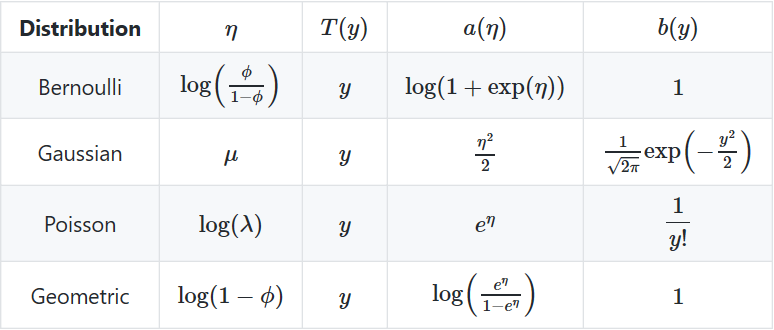

#### 1.2.4.2 General Approach to Construct GLM

Now that we have some bacis knowledge about exponential family distribution, we need to use this distribution for our modeling purpose.We need three important prerequisites or assumptions to make model built:
1. $y|x;\theta \sim Exponential Family(\eta)$

2. $h_\theta(x) = E[T(y)|x;\theta]$;This means given x, our target is to predict the expected value of T(y), or compute  $E[T(y)|x;\theta]$. Because in most cases, $T(y) = y$, so our purpose can be seen as predicting $E[y|x;\theta]$

3. The natural parameter $\eta$ and the inputs x are related linearly: $\eta = \theta ^T x$

With these three assumptions, we can easily derive many learning algorithms, and the resulting models are usually easy for modelling different types of distributions over y. We we derive logistic regression and ordinary least squares as GLMs.

$\text{I. From GLM to OLS}$

Assume that our target variable y is continuous and $y|x;\theta \sim N(\mu,\sigma ^ 2)$, and let us use our standard exponential family distribution $p(y;\eta) = b(y)exp(\eta^{T}T(y)-a(\eta))$ to be the Gaussian distribution.

As we proved before, when we convert Gaussian distribution to be Exponential Family Distribution, we have 
   $$\mu = \eta$$
and because  $y|x;\theta \sim N(\mu,\sigma ^ 2)$, which means $E[y|x;\theta] = \mu$
and again because our assumption 2 we mentioned before, which assumes that 
$$h_{\theta}(x) = E[y|x;\theta]$$

and our assumption 3 which assumes that $\eta = \theta^Tx$,

we can link those evidences together to get 

$$h_{\theta}(x) = E[y|x;\theta]$$

$$=\mu$$

$$=\eta$$

$$=\theta^Tx$$

So up to now, we can say that if we want to use OLS to predict output $h(x)$, we can derive it from GLMs, and our prediction should be $\theta ^T x$

$\text{From GLM to Logistic Regression}$

#### Reference
[1] Andrew Ng, Stanford University CS229 Notes http://cs229.stanford.edu/notes-spring2019/cs229-notes1.pdf

[2] ET Jaynes, Probability Theory: The Logic of Science  https://www.amazon.com/Probability-Theory-Science-T-Jaynes/dp/0521592712/ref=sr_1_1?crid=1OMSTNUGHLPNJ&keywords=probability+theory+the+logic+of+science&qid=1560988932&s=gateway&sprefix=Probability+Theory%3A+The%2Caps%2C129&sr=8-1

[3]Wikepedia Cross Validation (Statistics) https://en.wikipedia.org/wiki/Cross-validation_(statistics)

[4]Springer, Encyclopedia of System Biology https://link.springer.com/referenceworkentry/10.1007%2F978-1-4419-9863-7_255

[5]Data Driven Investor https://medium.com/datadriveninvestor/k-fold-cross-validation-6b8518070833

[6]Max Kuhn & Kjell, Johnson Applied Predictive Modeling, https://www.amazon.com/Applied-Predictive-Modeling-Max-Kuhn/dp/1461468485/ref=sr_1_1?crid=2SLC5RI2D4GWZ&keywords=applied+predictive+modelling&qid=1561144037&s=gateway&sprefix=Applied+Pred%2Caps%2C124&sr=8-1

In [627]:

import io

from IPython.nbformat import current


filepath = 'C:/Users/38516/CQF/Project.ipynb'
with io.open(filepath, 'r', encoding='utf-8') as f:

    nb = current.read(f, 'json')



word_count = 0

for cell in nb.worksheets[0].cells:

    if cell.cell_type == "markdown":

        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print(word_count)

2868
